In [1]:
!pip install awswrangler

In [2]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from sqlalchemy import create_engine
import os
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt

In [3]:
staging_path = 's3://will-prod-ml-platform-sagemaker-studio/staging/flavia-costa/'
boto3_session = boto3.Session(region_name='sa-east-1')

In [4]:
query = """

select 
date_trunc('month', ult_disparo_email) as mes_envio_email --ultimo mes
, date_trunc('month',  ult_disparo_push) as mes_envio_push
, date_trunc('month',  ult_disparo_sms) as mes_envio_sms
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
group by 1,2,3


"""

In [5]:
# Clean temporary folder
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


In [7]:
df.head()

,mes_envio_email,mes_envio_push,mes_envio_sms,clientes
0,2023-08-01,2023-06-01,2023-07-01,10403
1,2023-07-01,2023-07-01,None,178726
2,2023-03-01,2023-02-01,2023-03-01,10347
3,2023-07-01,2023-01-01,2023-03-01,299
4,2023-04-01,2023-08-01,2023-04-01,407


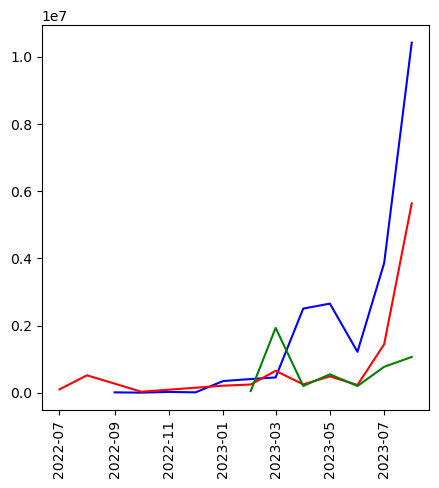

In [49]:
plt.figure(figsize = (5,5))
plt.plot(df.groupby('mes_envio_email').agg({'clientes':['sum']}), color = 'blue')
plt.plot(df.groupby('mes_envio_push').agg({'clientes':['sum']}), color = 'red')
plt.plot(df.groupby('mes_envio_sms').agg({'clientes':['sum']}), color = 'green')
plt.xticks(rotation=90)
plt.show()

In [50]:

query = """

select 
interacao_email
, interacao_push
, count(distinct cpf) as clientes
from martech_curated_zone.historico_acionamento_pmm_cliente
group by 1,2


"""


wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df2 = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

Started query


<AxesSubplot:xlabel='clientes', ylabel='interacao_email'>

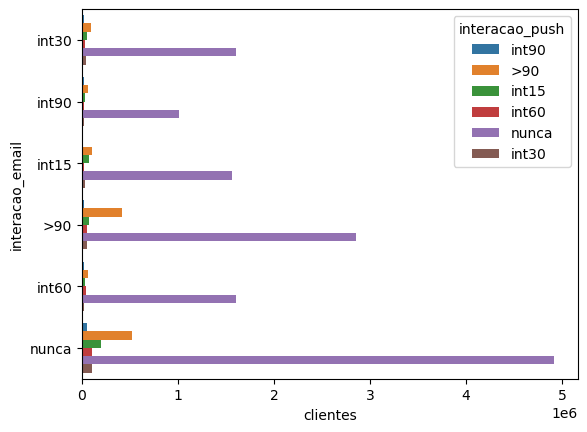

In [69]:
sns.barplot(data = df2, y = 'interacao_email', x = 'clientes', hue = 'interacao_push')

In [65]:
df2.sort_values(by = 'clientes', ascending = False).head(10)

,interacao_email,interacao_push,clientes
14,nunca,nunca,4919542
17,>90,nunca,2856178
33,int60,nunca,1602711
7,int30,nunca,1599580
26,int15,nunca,1566894
34,int90,nunca,1007963
18,nunca,>90,524602
9,>90,>90,421435
27,nunca,int15,195789
20,int15,>90,102343


In [37]:
query = """

select 
c.cpf
, max(p.ds_cluster_sociodemographic) as persona
, max(case when interacao_email <> 'nunca' then 1 else 0 end) as flag_email
, max(case when interacao_push <> 'nunca' then 1 else 0 end) as flag_push
from martech_curated_zone.historico_acionamento_pmm_cliente c
left join customer_curated_zone.ca_book_cliente cli on (cli.cpf = c.cpf)
left join customer_curated_zone.ca_book_cliente_cluster p on (p.id_customer = cli.id_customer) 
where (ult_disparo_email is not null or ult_disparo_push is not null)
and (interacao_email <> 'nunca' or interacao_push <> 'nunca')
group by 1
order by rand()
limit 500000


"""

# wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# # Run query
# print('Started query')

# df3 = wr.athena.read_sql_query(
#     sql=query,
#     database=None,
#     unload_approach=True,
#     ctas_approach=False,
#     boto3_session=boto3_session,
#     s3_output=staging_path
# )
# wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

from acessos import df_athena_q

df3 = df_athena_q('flavia-costa', query)


In [38]:
len(df3)

500000

In [39]:
df3

,cpf,persona,flag_email,flag_push
0,10065246497,"16 - Homem, 25 a 40 anos, Nordeste",1,0
1,08880560441,"16 - Homem, 25 a 40 anos, Nordeste",1,0
2,01030733457,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",0,1
3,04496368447,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",1,0
4,39884421862,"20 - Homem, Até 24 anos, Sudeste e Sul",1,0
...,...,...,...,...
499995,11214675980,"18 - Homem, 25 a 40 anos, Sudeste e Sul",1,0
499996,06145938595,"16 - Homem, 25 a 40 anos, Nordeste",1,0
499997,49370658823,"20 - Homem, Até 24 anos, Sudeste e Sul",1,0
499998,06725647340,"15 - Mulher, 25 a 40 anos, Nordeste",1,1


In [40]:
df3['segmento'] = np.where((df3['flag_email'] == 1) & (df3['flag_push'] == 1), "1 - Engajado em dois canais", 
                    np.where((df3['flag_email'] == 1) & (df3['flag_push'] == 0), "2 - Apenas Email",
                          np.where((df3['flag_email'] == 0) & (df3['flag_push'] == 1), "3 - Apenas Push", "NI")))


df3['segmento'].value_counts()

2 - Apenas Email               334179
1 - Engajado em dois canais    151741
3 - Apenas Push                 14080
Name: segmento, dtype: int64

In [41]:
df3['segmento'].value_counts(normalize = True)

2 - Apenas Email               0.668358
1 - Engajado em dois canais    0.303482
3 - Apenas Push                0.028160
Name: segmento, dtype: float64

In [45]:
for i in df3.persona.unique():
    print(i)
    print(df3[df3['persona'] == i]['segmento'].value_counts(normalize = True))

16 - Homem, 25 a 40 anos, Nordeste
2 - Apenas Email               0.635266
1 - Engajado em dois canais    0.327336
3 - Apenas Push                0.037399
Name: segmento, dtype: float64
0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste
2 - Apenas Email               0.584640
1 - Engajado em dois canais    0.374524
3 - Apenas Push                0.040836
Name: segmento, dtype: float64
14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste
2 - Apenas Email               0.584146
1 - Engajado em dois canais    0.372727
3 - Apenas Push                0.043126
Name: segmento, dtype: float64
20 - Homem, Até 24 anos, Sudeste e Sul
2 - Apenas Email               0.745370
1 - Engajado em dois canais    0.233727
3 - Apenas Push                0.020903
Name: segmento, dtype: float64
8 - Mulher, Solteira, Até 24 anos, cidade Pequena do Sudeste ou Sul
2 - Apenas Email               0.725272
1 - Engajado em dois canais    0.257192
3 - Apenas Push                0.017536
Name: 

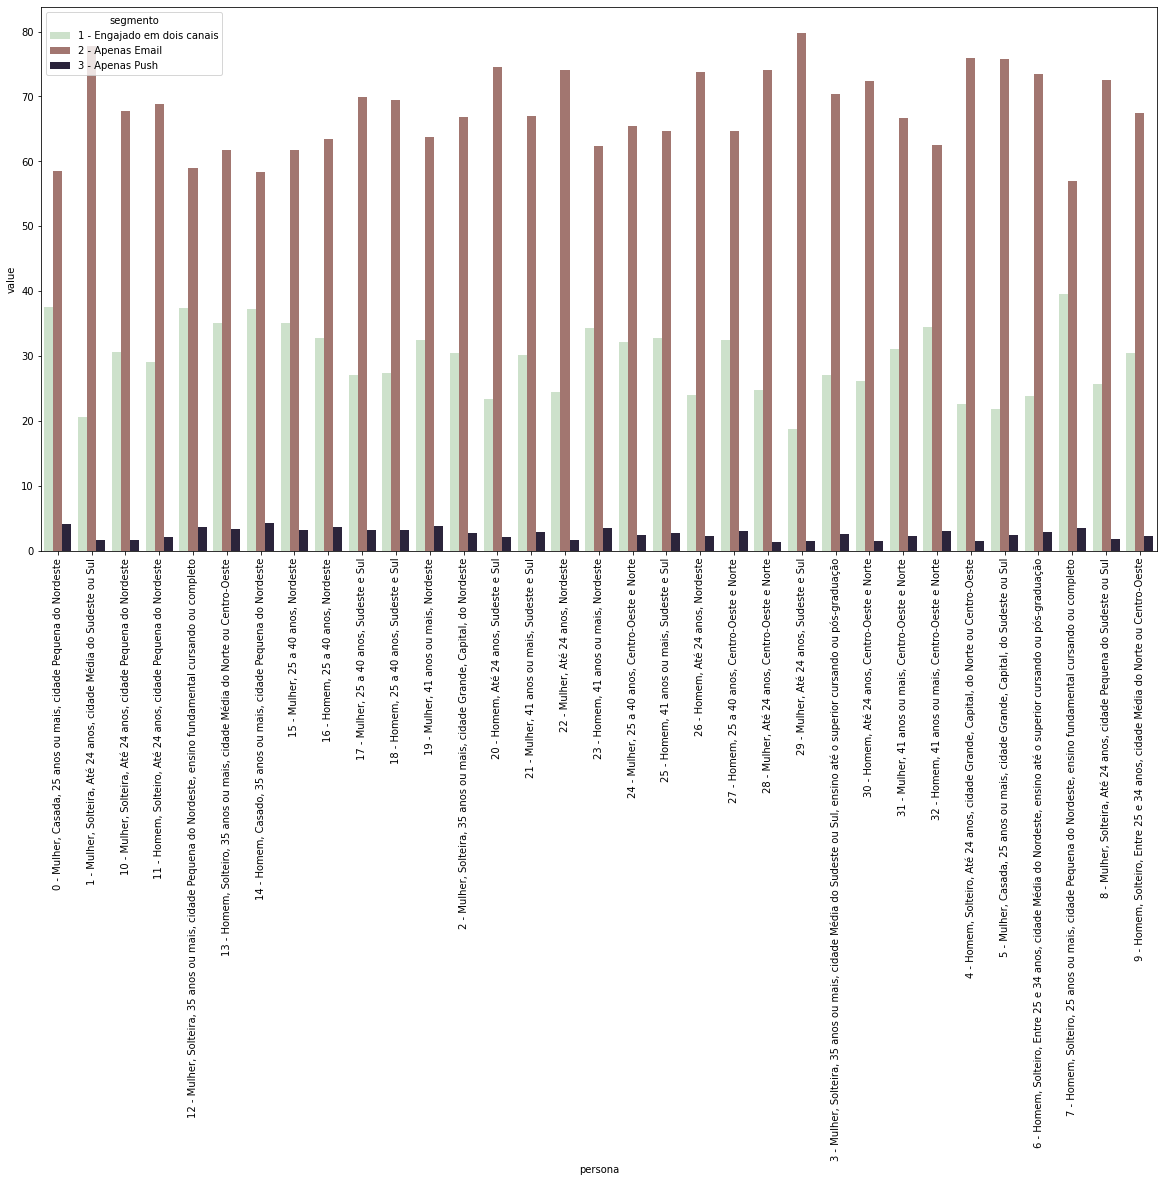

In [48]:
vars_agregacao = ['persona'] #vão estar no x. Precisam ser categóricas

for i in vars_agregacao:
    group_var = 'segmento' #vai estar na legenda
    x_var = i
    campo_contagem = 'count'
    agg = df3.groupby([i, group_var]).agg({'cpf':['count']}) #alterar nome do dataframe e variavel de contagem
    agg.columns = agg.columns.droplevel(0)
    agg = agg.reset_index()
    df_viz = agg.pivot_table(columns=x_var,index = group_var, values=campo_contagem, aggfunc=np.sum)

    for i in df_viz.columns:
        df_viz[i] = df_viz[i] / df_viz[i].sum()

    df_viz = df_viz.reset_index()
    df_viz = pd.melt(df_viz, id_vars=[group_var])
    df_viz['value'] = df_viz['value'] * 100
    x = df_viz[x_var].astype('str')
    y = df_viz[group_var].astype('str')
    z = df_viz.value.round(1)
    plt.figure(figsize = (20,10))
    sns.barplot(data = df_viz, x = x, y = z, hue = y, palette="ch:s=1,rot=-2")
    plt.xticks(rotation=90)
    plt.show()

In [52]:
df_viz.query('segmento == "2 - Apenas Email"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
67,2 - Apenas Email,"29 - Mulher, Até 24 anos, Sudeste e Sul",79.801211
4,2 - Apenas Email,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",77.666073
82,2 - Apenas Email,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",75.860397
85,2 - Apenas Email,"5 - Mulher, Casada, 25 anos ou mais, cidade Gr...",75.745367
40,2 - Apenas Email,"20 - Homem, Até 24 anos, Sudeste e Sul",74.536970
64,2 - Apenas Email,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",73.960306
46,2 - Apenas Email,"22 - Mulher, Até 24 anos, Nordeste",73.951145
58,2 - Apenas Email,"26 - Homem, Até 24 anos, Nordeste",73.776991
88,2 - Apenas Email,"6 - Homem, Solteiro, Entre 25 e 34 anos, cidad...",73.471960
94,2 - Apenas Email,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",72.527171


In [53]:
df_viz.query('segmento == "2 - Apenas Email"').sort_values(by = 'value', ascending=True).head(10)

,segmento,persona,value
91,2 - Apenas Email,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",56.965589
19,2 - Apenas Email,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",58.414634
1,2 - Apenas Email,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",58.463958
13,2 - Apenas Email,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",58.967658
16,2 - Apenas Email,"13 - Homem, Solteiro, 35 anos ou mais, cidade ...",61.741425
22,2 - Apenas Email,"15 - Mulher, 25 a 40 anos, Nordeste",61.783772
49,2 - Apenas Email,"23 - Homem, 41 anos ou mais, Nordeste",62.332440
79,2 - Apenas Email,"32 - Homem, 41 anos ou mais, Centro-Oeste e Norte",62.549615
25,2 - Apenas Email,"16 - Homem, 25 a 40 anos, Nordeste",63.526570
34,2 - Apenas Email,"19 - Mulher, 41 anos ou mais, Nordeste",63.678606


In [54]:
df_viz.query('segmento == "3 - Apenas Push"').sort_values(by = 'value', ascending=False).head(10)

,segmento,persona,value
20,3 - Apenas Push,"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",4.312639
2,3 - Apenas Push,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",4.083600
35,3 - Apenas Push,"19 - Mulher, 41 anos ou mais, Nordeste",3.780252
26,3 - Apenas Push,"16 - Homem, 25 a 40 anos, Nordeste",3.739867
14,3 - Apenas Push,"12 - Mulher, Solteira, 35 anos ou mais, cidade...",3.582707
92,3 - Apenas Push,"7 - Homem, Solteiro, 25 anos ou mais, cidade P...",3.430657
50,3 - Apenas Push,"23 - Homem, 41 anos ou mais, Nordeste",3.402272
17,3 - Apenas Push,"13 - Homem, Solteiro, 35 anos ou mais, cidade ...",3.254178
23,3 - Apenas Push,"15 - Mulher, 25 a 40 anos, Nordeste",3.206469
32,3 - Apenas Push,"18 - Homem, 25 a 40 anos, Sudeste e Sul",3.168940


In [55]:
df_viz.query('segmento == "3 - Apenas Push"').sort_values(by = 'value', ascending=True).head(10)

,segmento,persona,value
65,3 - Apenas Push,"28 - Mulher, Até 24 anos, Centro-Oeste e Norte",1.276456
68,3 - Apenas Push,"29 - Mulher, Até 24 anos, Sudeste e Sul",1.382383
74,3 - Apenas Push,"30 - Homem, Até 24 anos, Centro-Oeste e Norte",1.465911
83,3 - Apenas Push,"4 - Homem, Solteiro, Até 24 anos, cidade Grand...",1.502666
47,3 - Apenas Push,"22 - Mulher, Até 24 anos, Nordeste",1.637638
8,3 - Apenas Push,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1.721266
5,3 - Apenas Push,"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",1.730720
95,3 - Apenas Push,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",1.753585
41,3 - Apenas Push,"20 - Homem, Até 24 anos, Sudeste e Sul",2.090321
11,3 - Apenas Push,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...",2.141518


In [56]:
print(df3['persona'].unique())

['16 - Homem, 25 a 40 anos, Nordeste'
 '0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste'
 '14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste'
 '20 - Homem, Até 24 anos, Sudeste e Sul'
 '8 - Mulher, Solteira, Até 24 anos, cidade Pequena do Sudeste ou Sul'
 '21 - Mulher, 41 anos ou mais, Sudeste e Sul'
 '17 - Mulher, 25 a 40 anos, Sudeste e Sul'
 '19 - Mulher, 41 anos ou mais, Nordeste' None
 '27 - Homem, 25 a 40 anos, Centro-Oeste e Norte'
 '25 - Homem, 41 anos ou mais, Sudeste e Sul'
 '26 - Homem, Até 24 anos, Nordeste'
 '10 - Mulher, Solteira, Até 24 anos, cidade Pequena do Nordeste'
 '15 - Mulher, 25 a 40 anos, Nordeste'
 '2 - Mulher, Solteira, 35 anos ou mais, cidade Grande, Capital, do Nordeste'
 '23 - Homem, 41 anos ou mais, Nordeste'
 '30 - Homem, Até 24 anos, Centro-Oeste e Norte'
 '9 - Homem, Solteiro, Entre 25 e 34 anos, cidade Média do Norte ou Centro-Oeste'
 '12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental 

Pontos importantes

- Campanhas muito concentradas em email
- Investigar o pouco engajamento de push
- Muitos clientes com engajamento apenas em email e isso varia de acordo com características do cliente
- Um modelo seria viável no momento apemas para propensão em email mas não performaria bem para push
- Caso o modelo seja multicanal definir se o modelo vai considerar como target o engajamento + conversão após

To do
- ppt rápido + pontos acima
- nova reunião e próximos passos